In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import geom
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import LogisticRegression as LogR
from sklearn.tree import DecisionTreeRegressor as DT

In [2]:
n = 5000
df = pd.DataFrame()
df['age'] = np.random.randint(25, 76, size=n)

In [3]:
df

,age
0,41
1,69
2,47
3,52
4,69
...,...
4995,60
4996,69
4997,59
4998,26


In [4]:
a=-10.5
b=0.05
timeout = 365*3

In [5]:
prob_values = 1/(1+np.exp(-a-b*df['age']))

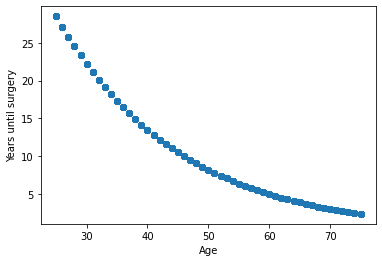

In [6]:
plt.scatter(df['age'],1/(365*prob_values))
plt.xlabel('Age')
plt.ylabel('Years until surgery');

In [7]:
days = geom(prob_values).rvs()
df['observation'] = np.where(days <= timeout, days, np.nan)
df

,age,observation
0,41,NaN
1,69,NaN
2,47,NaN
3,52,NaN
4,69,28.0
...,...,...
4995,60,725.0
4996,69,NaN
4997,59,NaN
4998,26,NaN


In [8]:
(df['observation'].isna()).mean()

0.6498

In [9]:
days.max()/365

149.82739726027398

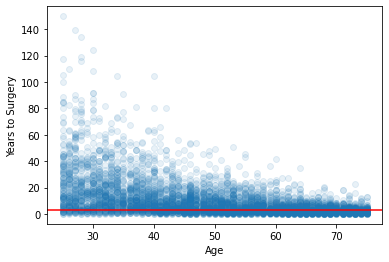

In [10]:
plt.scatter(df['age'],days/365, alpha=.1)
plt.axhline(timeout/365, color='red')
plt.xlabel('Age')
plt.ylabel('Years to Surgery');

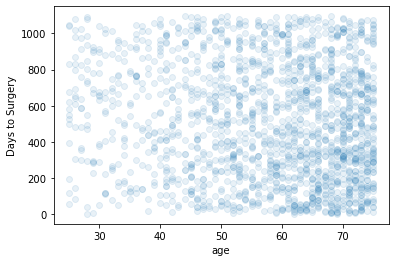

In [11]:
plt.scatter(df['age'], df['observation'], alpha = .1)
plt.xlabel('age')
plt.ylabel('Days to Surgery');

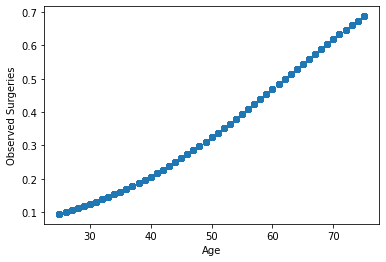

In [12]:
S = LogR().fit(df[['age']],df['observation'].isna()).predict_proba(df[['age']])[:,0]
plt.scatter(df['age'], S)
plt.xlabel('Age')
plt.ylabel('Observed Surgeries');

In [13]:
df['imputed_days'] = np.where(df['observation'].isna(), timeout + (1/(1-(1-S)**(1/timeout))), df['observation'])
df

,age,observation,imputed_days
0,41,NaN,5579.416155
1,69,NaN,2278.015271
2,47,NaN,4358.532442
3,52,NaN,3628.341173
4,69,28.0,28.000000
...,...,...,...
4995,60,725.0,725.000000
4996,69,NaN,2278.015271
4997,59,NaN,2909.694363
4998,26,NaN,11510.658406


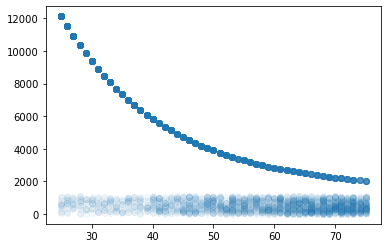

In [14]:
plt.scatter(df['age'], df['imputed_days'], alpha = .05)

In [15]:
df['probability'] = 1/DT().fit(df[['age']], df['imputed_days']).predict(df[['age']])
df

,age,observation,imputed_days,probability
0,41,NaN,5579.416155,0.000254
1,69,NaN,2278.015271,0.000765
2,47,NaN,4358.532442,0.000319
3,52,NaN,3628.341173,0.000385
4,69,28.0,28.000000,0.000765
...,...,...,...,...
4995,60,725.0,725.000000,0.000543
4996,69,NaN,2278.015271,0.000765
4997,59,NaN,2909.694363,0.000578
4998,26,NaN,11510.658406,0.000100


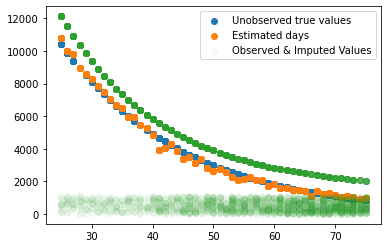

In [16]:
plt.scatter(df['age'],1/prob_values, label = 'Unobserved true values');
plt.scatter(df['age'], 1/df['probability'], label = 'Estimated days')
plt.scatter(df['age'], df['imputed_days'], alpha = .05, label = 'Observed & Imputed Values')
plt.legend()

In [17]:
log_odds = np.log(df['probability']/(1-df['probability']))
log_odds

0      -8.276851
1      -7.174766
2      -8.051164
3      -7.862545
4      -7.174766
          ...   
4995   -7.517956
4996   -7.174766
4997   -7.455980
4998   -9.209350
4999   -8.968573
Name: probability, Length: 5000, dtype: float64

In [18]:
lr = LR().fit(df[['age']], log_odds)

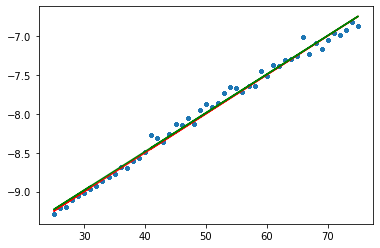

In [19]:
plt.scatter(df['age'], log_odds, s=10)
plt.plot(df['age'], df['age']*b+a, color = 'red')
plt.plot(df['age'], lr.predict(df[['age']]), color = 'green');

In [20]:
lr.intercept_, a

(-10.46805943035277, -10.5)

In [21]:
lr.coef_, b

(array([0.04959263]), 0.05)

In [22]:
df['target']= df['probability'].apply(lambda p:geom(p).cdf(18*30)-geom(p).cdf(6*30))
df

,age,observation,imputed_days,probability,target
0,41,NaN,5579.416155,0.000254,0.083570
1,69,NaN,2278.015271,0.000765,0.209838
2,47,NaN,4358.532442,0.000319,0.102346
3,52,NaN,3628.341173,0.000385,0.120709
4,69,28.0,28.000000,0.000765,0.209838
...,...,...,...,...,...
4995,60,725.0,725.000000,0.000543,0.161049
4996,69,NaN,2278.015271,0.000765,0.209838
4997,59,NaN,2909.694363,0.000578,0.169251
4998,26,NaN,11510.658406,0.000100,0.034760


/Users/landbelenky/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


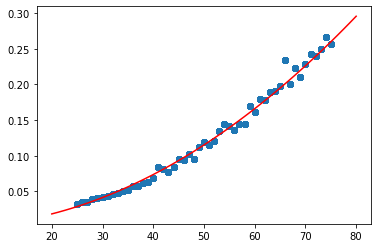

In [23]:
plt.scatter(df['age'], df['target'])
ages = np.linspace(20, 80)
plt.plot(ages, np.exp(LR().fit(np.log(df[['age']]),
                                       np.log(df['target'])
                                      )
                              .predict(np.log(ages.reshape(-1,1)))),
                            color = 'red');
